In [ ]:
%load_ext autoreload
%autoreload 2

In [73]:
import os
import pathlib

while pathlib.Path(".").absolute().name != "aerial-disentangled-representations":
    os.chdir("..")

In [74]:
os.environ["NO_ALBUMENTATIONS_UPDATE"] = "1"
import albumentations as A

no_transform = A.Compose([])

In [84]:
from albumentations.pytorch import ToTensorV2

shared_shared_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.ShiftScaleRotate(
        shift_limit=0.0625, scale_limit=0.1,
        rotate_limit=15, border_mode=0, p=0.5
    ),
    A.Perspective(scale=(0.02, 0.05), p=0.3),
])

noise_transform = A.Compose([
    A.OneOf([
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
        A.ChannelShuffle(),
    ], p=0.8),

    A.OneOf([
        A.GaussianBlur(blur_limit=(3, 7)),
        A.MotionBlur(blur_limit=(3, 7)),
    ], p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),

    A.Normalize(mean=(0.5, 0.5, 0.5),
                std=(0.5, 0.5, 0.5)),
    ToTensorV2(),
])

In [87]:
from disentangled_representations.src.data_processing.aerial_datasets import VPairDistractorsDataset, \
    LEVIR_CDPlus_Dataset, SYSU_CD_Dataset, S2LookingDataset, Hi_UCD_Dataset, GVLM_CD_Dataset

VPair_dataset = VPairDistractorsDataset(read_color=True, transform=no_transform)

LEVIR_dataset_train = LEVIR_CDPlus_Dataset(split="train", read_color=True, shared_transform=
A.Compose([
    A.RandomResizedCrop(
        height=256, width=256,
        scale=(0.4, 0.75), ratio=(0.95, 1 / 0.95), p=1.0
    ),
    shared_shared_transform,
], additional_targets=additional_targets), unique_transform=noise_transform)

SYSU_dataset_train = SYSU_CD_Dataset(split="train", read_color=True, shared_transform=A.Compose([A.RandomResizedCrop(
    height=256, width=256,
    scale=(0.9, 1), ratio=(0.95, 1 / 0.95), p=1.0
), shared_shared_transform, ]), unique_transform=noise_transform)

S2Looking_dataset_train = S2LookingDataset(split="train", read_color=True, shared_transform=A.Compose([
    A.RandomResizedCrop(
        height=256, width=256,
        scale=(0.4, 0.75), ratio=(0.95, 1 / 0.95), p=1.0
    ),
    shared_shared_transform,
]), unique_transform=noise_transform)

Hi_UCD_dataset_train = Hi_UCD_Dataset(split="train", read_color=True, shared_transform=A.Compose([
    A.RandomResizedCrop(
        height=256, width=256,
        scale=(0.75, 1.0), ratio=(0.95, 1 / 0.95), p=1.0
    ),
    shared_shared_transform,
]), unique_transform=noise_transform)

GVLM_dataset = GVLM_CD_Dataset(read_color=True, shared_transform=A.Compose([
    A.RandomResizedCrop(
        height=256, width=256,
        scale=(0.1, 0.5), ratio=(0.95, 1 / 0.95), p=1.0
    ),
    shared_shared_transform,
]), unique_transform=noise_transform)

In [93]:
import torch

dataset_weights_mapping_train: dict[torch.utils.data.Dataset, float] = {
    LEVIR_dataset_train: 2.0,
    SYSU_dataset_train: 0.1,
    S2Looking_dataset_train: 0.5,
    Hi_UCD_dataset_train: 0.3,
    GVLM_dataset: 25
}

{ds.__class__.__name__: len(ds) for ds in dataset_weights_mapping_train.keys()}

{'LEVIR_CDPlus_Dataset': 637,
 'SYSU_CD_Dataset': 12000,
 'S2LookingDataset': 3500,
 'Hi_UCD_Dataset': 12000,
 'GVLM_CD_Dataset': 17}

In [94]:
from disentangled_representations.src.data_processing.mixed_sampler import MixedResamplingSampler

sampler = MixedResamplingSampler(
    dataset_weights_mapping_train,
    shuffle=True
)

len(sampler)

8249

In [95]:
from disentangled_representations.src.data_processing.data_loaders import create_train_data_loader
from torch.utils.data import ConcatDataset

complete_train_ds = ConcatDataset(list(dataset_weights_mapping_train.keys()))

train_data_loader = create_train_data_loader(complete_train_ds, batch_size=16, num_workers=4)

In [ ]:
batch_example = next(iter(train_data_loader))

In [101]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils


def visualize_batch_pairs(batch, n=4):
    imgs_A, imgs_B = batch
    imgs_A, imgs_B = imgs_A[:n], imgs_B[:n]

    imgs_A = (imgs_A + 1.0) / 2.0
    imgs_B = (imgs_B + 1.0) / 2.0

    grid_A = vutils.make_grid(imgs_A, nrow=n, padding=4)
    grid_B = vutils.make_grid(imgs_B, nrow=n, padding=4)

    np_A = grid_A.permute(1, 2, 0).cpu().numpy()
    np_B = grid_B.permute(1, 2, 0).cpu().numpy()

    fig, axes = plt.subplots(2, 1, figsize=(n * 2, 4))
    axes[0].imshow(np_A)
    axes[0].set_title("View A")
    axes[1].imshow(np_B)
    axes[1].set_title("View B")
    for ax in axes:
        ax.axis("off")
    plt.tight_layout()
    plt.show()


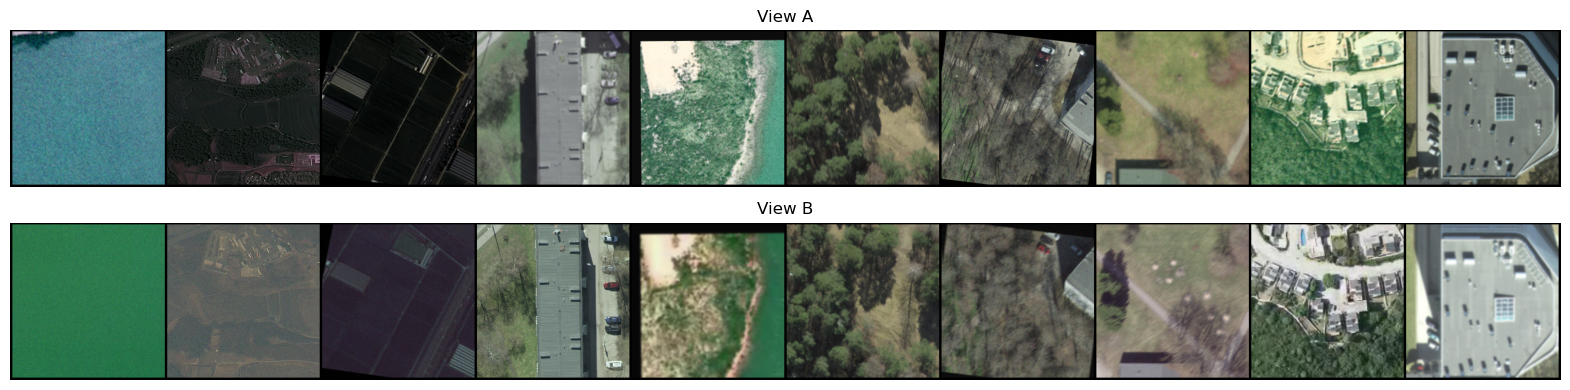

In [107]:
visualize_batch_pairs(batch_example, 10)